# Testis Pilot scRNA-Seq

<!--NAVIGATION-->
| [Contents](Index.ipynb) | [Combined Pilot scRNA-Seq](03.00-combined_ovary_and_testis_pilot_scRNAseq_analysis.ipynb) >

In [1]:
import os
import sys
from pathlib import Path
import string
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs, TSNEPlot

# Setup notebook
nbconfig = Nb.setup_notebook('testis_pilog_scRNAseq_analysis')

# Turn on cache
from joblib import Memory
memory = Memory(cachedir=nbconfig.cache, verbose=0)

%reload_ext rpy2.ipython

last updated: 2017-12-08 
Git hash: ed7f5ff8f6938ca71fd29128094925cea3f9feb2


In [186]:
REF = os.environ['REFERENCES_DIR']
OUTPUT = '../output/testes_scRNAseq_pilot'
Path(OUTPUT).mkdir(exist_ok=True)

# Import gene annotations
fbgn2symbol = pd.read_csv(str(Path(REF, 'dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation')), sep='\t', 
                          usecols=['gene_symbol', 'primary_FBgn'], index_col='primary_FBgn').to_dict()['gene_symbol']

symbol2fbgn = pd.read_csv(str(Path(REF, 'dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation')), sep='\t', 
                          usecols=['gene_symbol', 'primary_FBgn'], index_col='gene_symbol').to_dict()['primary_FBgn']

In [3]:
%%R -i REF -i OUTPUT
# Import R libraries
.libPaths("/data/fearjm/miniconda3/envs/larval_gonad/lib/R/library")
library(Seurat)
library(dplyr)
library(Matrix)

Here we use [Seurat](http://satijalab.org/seurat/) for the initial analysis. From their website:

>Seurat is an R package designed for QC, analysis, and exploration of single cell RNA-seq data. Seurat aims to enable users to identify and interpret sources of heterogeneity from single cell transcriptomic measurements, and to integrate diverse types of single cell data.o

## Quality Control

We keep all genes that are expressed in **≥3 cells**, and we kept all cells that capture **≥200 detected genes**. The vast majority of cells have around 2,000 touched genes, with some cells haveing more than 6,000 detected genes. The distribution of number of unique molecular indices (nUMI) is much tighter with the majority of cells having around 10,000 UMI. The number of detected genes is moderately correlated with the UMI count. 

In [7]:
%%R -o meta_data -o raw_data
# Load the testis dataset
testis.data = Read10X(data.dir="../output/testis1/outs/filtered_gene_bc_matrices/dm6.16")

# Initialize the Seurat object with the raw (non-normalized data).
# Keep all genes expressed in >= 3 cells (~0.1% of the data). Keep all cells with at least 200 detected genes
testis = CreateSeuratObject(raw.data = testis.data, min.cells = 3, min.genes = 200, project = "10X_testis")
nCells = dim(testis@meta.data)[1]
meta_data = as.data.frame(testis@meta.data)
raw_data = as.data.frame(as.matrix(testis@raw.data))

write.table(meta_data,
            file=file.path(OUTPUT, 'metadata.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

write.table(raw_data,
            file=file.path(OUTPUT, 'raw.tsv'),
            quote=FALSE, sep='\t', row.names=TRUE, col.names=TRUE)

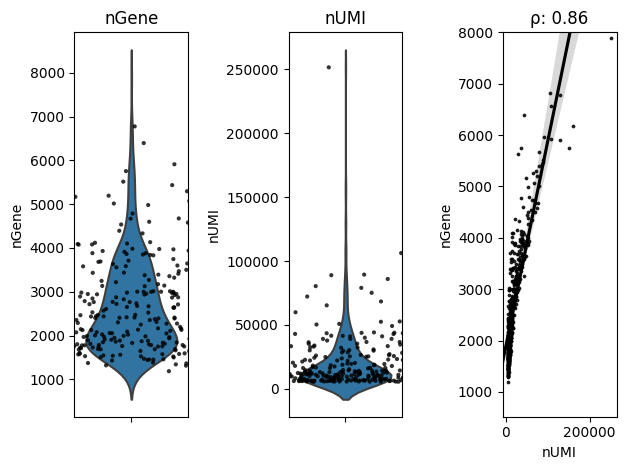

In [5]:
# Plot distribution of gene counts and UMI counts
@make_figs(nbconfig.fig_name('nGene_nUMI_panel'),
           styles=nbconfig.styles_wide, formats=nbconfig.formats)
def plot_nGene_nUMI_panel():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
    sns.violinplot(y=meta_data.nGene, ax=ax1, inner=None)
    sns.stripplot(y=meta_data.nGene, color='k', ax=ax1, jitter=1.02, size=3, alpha=.8)
    
    sns.violinplot(y=meta_data.nUMI, ax=ax2, inner=None)
    sns.stripplot(y=meta_data.nUMI, ax=ax2, color='k', jitter=1.02, size=3, alpha=.8)
    
    sns.regplot('nUMI', 'nGene', meta_data, color='k', ax=ax3, scatter_kws={'s': 3})

    ax1.set_title('nGene')
    ax2.set_title('nUMI')
    
    rho = np.round(stats.pearsonr(meta_data.nGene, meta_data.nUMI)[0], 2)
    ax3.set_title(f'ρ: {rho}')
    ax3.set_ylim(None, 8000)
    plt.tight_layout()
    
plot_nGene_nUMI_panel()

To try to avoid cells that behave like outliers, we filtered cells that had a gene count ≤200 or ≥6,000.

In [43]:
%%R
testis = FilterCells(object=testis, subset.names=c("nGene"), low.thresholds=c(200), high.thresholds=c(6000))

The moderate correlation of nGene and nUMI suggests that the majority of genes will have an overall low number of reads / gene. Looking at the distribution of cells with ≤1 read per gene or ≤5 reads pergene shows that the majority of cells have around 90 percent of genes with 1 or fewer reads.

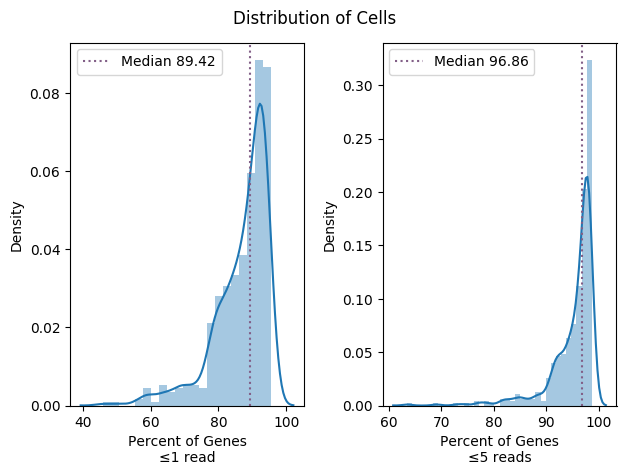

In [42]:
@make_figs(nbconfig.fig_name('distribution_percent_low_count_genes'), styles=nbconfig.styles_wide, 
          kws_layout={'rect': [0, 0, 1, .95]})
def _plot():
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    low1 = (raw_data <= 1).sum() / raw_data.shape[0] * 100
    low1med = low1.median()
    low2 = (raw_data <= 5).sum() / raw_data.shape[0] * 100
    low2med = low2.median()

    sns.distplot(low1, ax=ax1)
    ax1.axvline(low1med, ls=':', color=nbconfig.color_c1, label=f'Median {low1med:0.2f}')
    
    sns.distplot(low2, ax=ax2)
    ax2.axvline(low2med, ls=':', color=nbconfig.color_c1, label=f'Median {low2med:0.2f}')

    plt.suptitle('Distribution of Cells')
    
    ax1.set_xlabel("Percent of Genes\n≤1 read")
    ax1.set_ylabel('Density')
    ax1.legend()
    
    ax2.set_xlabel("Percent of Genes\n≤5 reads")
    ax2.set_ylabel('Density')
    ax2.legend()
    
_plot()

## Normalization

Next we normalized the data. Seurat's normalizes gene expression by the total expression for each cell, multiplies by a scaling factors (10,000), and takes the natural log.

In [47]:
%%R -o norm
testis = NormalizeData(object=testis, normalization.method="LogNormalize", scale.factor=1e4)
norm = as.data.frame(as.matrix(testis@data))

write.table(norm, file=file.path(OUTPUT, 'normalized_read_counts.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

## Variable Genes

Next Seurat identifies variable genes for use in downstream analysis. For doing differential expression and clustering focusing on the variable genes speeds up analysis.  Firt, average expression and dispersion (variation) are calculated for each gene. Then genes are binned controling for the relationship between variability and average expression. Here we select genes (n=2,588) in the white area to cary through to the analysis.

In [48]:
%%R -o dispersion 
### Detection of variable genes across the single cells
testis = FindVariableGenes(object=testis, mean.function=ExpMean, dispersion.function=LogVMR, do.plot=FALSE,
                           x.low.cutoff=0.01, 
                           x.high.cutoff=3, 
                           y.cutoff=0.5,
                           y.high.cutoff=Inf
                          )

dispersion = as.data.frame(as.matrix(testis@hvg.info))

write.table(dispersion,
            file=file.path(OUTPUT, 'dispersion.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

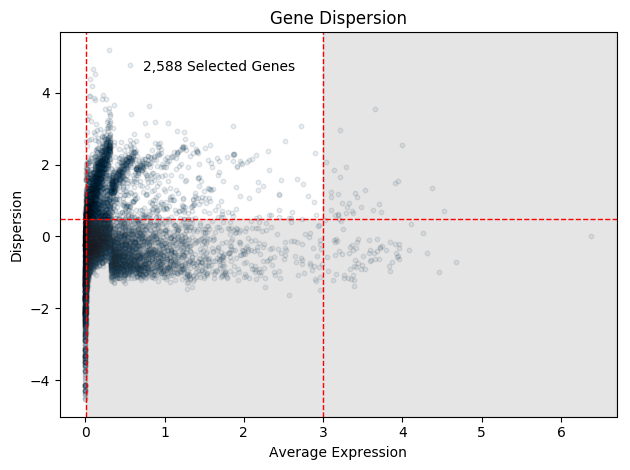

In [65]:
@make_figs(nbconfig.fig_name('gene_dispersion'))
def plot_dispersion():
    _x_low = 0.01
    _x_high = 3
    _y_low = 0.5

    fig, ax = plt.subplots(1, 1)
    ax.scatter(dispersion['gene.mean'], dispersion['gene.dispersion.scaled'], 
                s=10, alpha=.1, edgecolor='k')
    ax.axvline(_x_low, ls='--', lw=1, color='r')
    ax.axvline(_x_high, ls='--', lw=1, color='r')
    ax.axhline(_y_low, ls='--', lw=1, color='r')

    _x_min, _x_max = ax.get_xlim()
    _y_min, _y_max = ax.get_ylim()

    verts = [
        [_x_low, _y_min], 
        [_x_low, _y_low], 
        [_x_high, _y_low], 
        [_x_high, _y_max],
        [_x_max, _y_max],
        [_x_max, _y_min],
    ]
    p1 = mpl.patches.Polygon(verts, color='grey', alpha=.2)
    ax.add_patch(p1)
    ax.set_title('Gene Dispersion')
    ax.set_xlabel('Average Expression')
    ax.set_ylabel('Dispersion')
    
    _num = sum((_x_low < dispersion['gene.mean']) & (_x_high > dispersion['gene.mean']) & (_y_low < dispersion['gene.dispersion.scaled']))
    ax.text(.15, .9, f'{_num:,} Selected Genes', transform=ax.transAxes)
    
plot_dispersion()

## Scaling and regressing out unwanted sources of variation

Next we regress out variability due to the number of UMI. To remove these 'unwanted' sources of variability, Seurat constructs a linear model and predicts gene expression based on the selected variables (i.e., nUMI). The scaled z-scores of the residuals are then used for dimensionality reduction and clustering.

**TODO: Revist this step and look into regressing out other sources including [pct.mito, cell-cycle genes, stress genes]. This may be useful for batch effects once we get more data.**

In [68]:
%%R
testis = ScaleData(object=testis, vars.to.regress=c("nUMI"), display.progress=FALSE)

write.table(as.data.frame(testis@scale.data),
            file=file.path(OUTPUT, 'scaled.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

## Dimensionality Reduction

Next we use PCA to reduce the dimensionality of the dataset. Selection of the number of principal components can be tricky. Here I looked at a variety of metrics and selected 30 PC's for use in remaining analysis.

First I show the typical PCA plot with PC1 vs PC2. As previously discussed, most genes have very low expression/variabilty and end up clusterd near 0. There is a set of a few genes that show a lot of spread on PC1 and a different set that show spread on PC2. Next, I show the top 30 genes with the largest loadings for PC1 and PC2. These genes should be the most variable genes in the data set. Most of them are CGS, but *vas* stands out. Looking at the Elbow plot and Jackstraw plots, using 30 PCs seems reasonable.

In [139]:
%%R -o pca_res -o gene_loadings -o pca_stdev
### Perform linear dimensional reduction
testis = RunPCA(object=testis, pc.genes=testis@var.genes, do.print=FALSE, 
                pcs.print=1:5, genes.print=5, pcs.compute=100)

# ProjectPCA scores each gene in the dataset (including genes not included in the PCA) based on their correlation
# with the calculated components. Though we don't use this further here, it can be used to identify markers that
# are strongly correlated with cellular heterogeneity, but may not have passed through variable gene selection.
# The results of the projected PCA can be explored by setting use.full=T in the functions above
testis = ProjectPCA(object=testis, do.print=FALSE)

pca_res = as.data.frame(testis@dr$pca@cell.embeddings)
gene_loadings = as.data.frame(testis@dr$pca@gene.loadings)
pca_stdev = testis@dr$pca@sdev

write.table(pca_res,
            file=file.path(OUTPUT, 'principal_components_cell.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

write.table(gene_loadings,
            file=file.path(OUTPUT, 'principal_components_gene.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

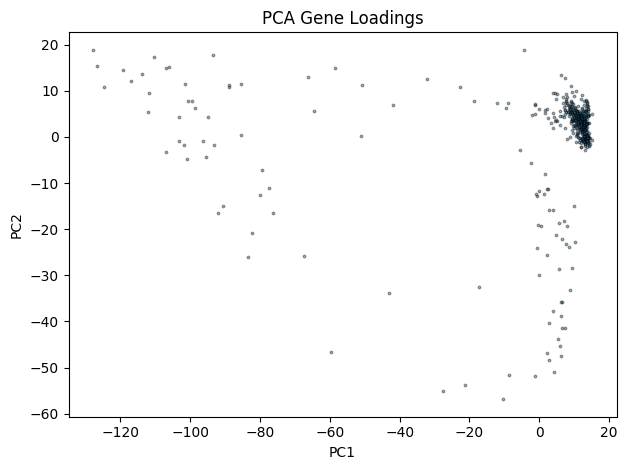

In [199]:
@make_figs(nbconfig.fig_name('pca_plot'), styles=nbconfig.styles)
def plot_pca2():
    # Adjust sign for PCs

    fig, ax = plt.subplots(1, 1)
    ax.scatter(pca_res.PC1, pca_res.PC2, alpha=.4, s=3, edgecolor='k')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('PCA Gene Loadings')
    
plot_pca2()

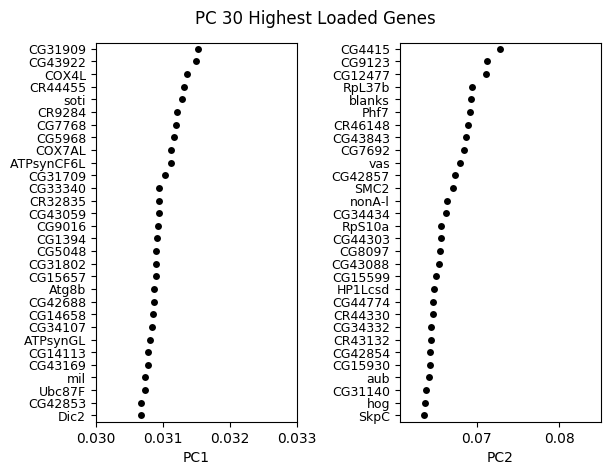

In [148]:
@make_figs(nbconfig.fig_name('pca_highest'), styles=nbconfig.styles_wide, kws_layout={"rect": [0, 0, 1, .95]})
def plot_pca1():
    # Adjust sign for PCs
    ## Sign is irrelavant with PCs, I am curious at looking at most variable
    pc1 = abs(gene_loadings.PC1).sort_values(ascending=False).head(30).reset_index()
    pc2 = abs(gene_loadings.PC2).sort_values(ascending=False).head(30).reset_index()

    fig, (ax1, ax2) = plt.subplots(1, 2)

    def adjust_font(ax):
        labels = []
        for l in ax.get_yticklabels():
            labels.append(fbgn2symbol[l.get_text()])
        ax.set_yticklabels(labels, fontsize=9)
        
    sns.stripplot(x="PC1", y="index", data=pc1, ax=ax1, color='k')
    ax1.set_xlim(0.03, 0.033)
    ax1.set_ylabel('')
    adjust_font(ax1)

    sns.stripplot(x="PC2", y="index", data=pc2, ax=ax2, color='k')
    ax2.set_ylabel('')
    adjust_font(ax2)
    
    plt.suptitle('PC 30 Highest Loaded Genes')
    
plot_pca1()

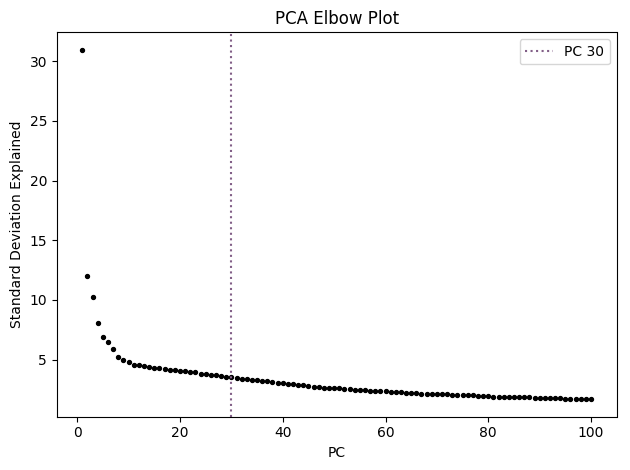

In [142]:
@make_figs(nbconfig.fig_name('pca_elbow'))
def plot_elbow():
    fig, ax = plt.subplots(1, 1)
    ax.scatter(range(1, 101), pca_stdev, color='k', s=8)
    ax.set_xlabel('PC')
    ax.set_ylabel('Standard Deviation Explained')
    ax.set_title('PCA Elbow Plot')
    ax.axvline(30, ls=':', color=nbconfig.color_c1, label='PC 30')
    ax.legend()

plot_elbow()

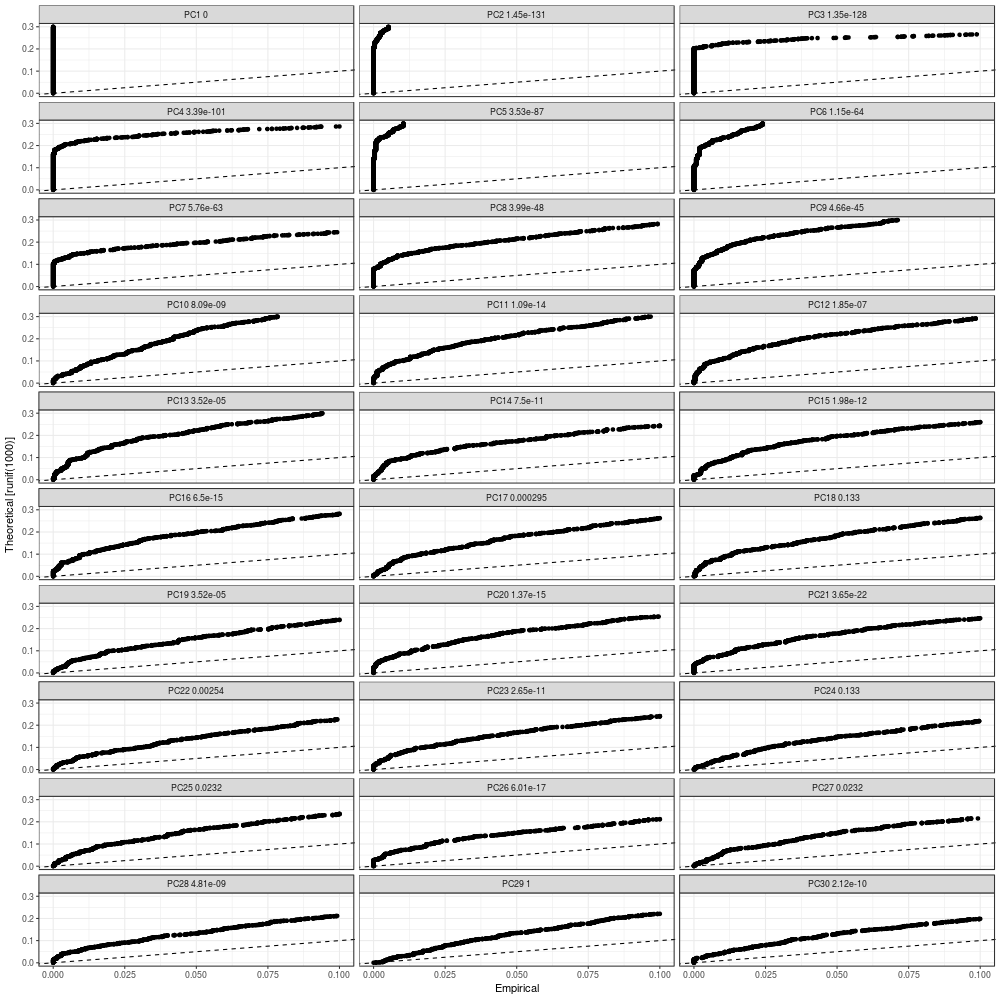

In [178]:
%%R -w 1000 -h 1000
testis = JackStraw(object=testis, num.replicate=100, do.print=FALSE, num.pc=30)

JackStrawPlot(object=testis, PCs=1:30)

## Cluster Cells

Clusters are generated using a grpahical K-nearest neighbors approach. This approach draws edges between cells with a similar expression pattern. It then tries to partition connected cells based on their local neighborhoods. For clustering I use the 30 PCs.

In [179]:
%%R -o ident
testis = FindClusters(object=testis, reduction.type="pca", dims.use=1:30, 
                      resolution=0.6, print.output=0, save.SNN=TRUE)

PrintFindClustersParams(object=testis)
# While we do provide function-specific printing functions, the more general function to
# print calculation parameters is PrintCalcParams().

ident = as.data.frame(testis@ident)
colnames(ident) = c('ident')

write.table(ident,
            file=file.path(OUTPUT, 'clusters.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

Parameters used in latest FindClusters calculation run on: 2017-12-08 18:10:38
Resolution: 0.6
-----------------------------------------------------------------------------
Modularity Function    Algorithm         n.start         n.iter
     1                   1                 100             10
-----------------------------------------------------------------------------
Reduction used          k.param          k.scale          prune.SNN
     pca                 30                25              0.0667
-----------------------------------------------------------------------------
Dims used in calculation
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
30



# Non-linear dimensioality reduction (tSNE)

Finally we can perform a non-linear dimensionality reduction, also using the PCs, and project these into 2-dimensional space using tSNE.

In [180]:
%%R -o tsne
### Run Non-linear dimensional reduction (tSNE)
testis = RunTSNE(object=testis, dims.use=1:30, do.fast=TRUE)

tsne = as.data.frame(testis@dr$tsne@cell.embeddings)

write.table(tsne,
            file=file.path(OUTPUT, 'tsne.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

# Save 
save(testis, file = file.path(OUTPUT, "seurat.Robj"))

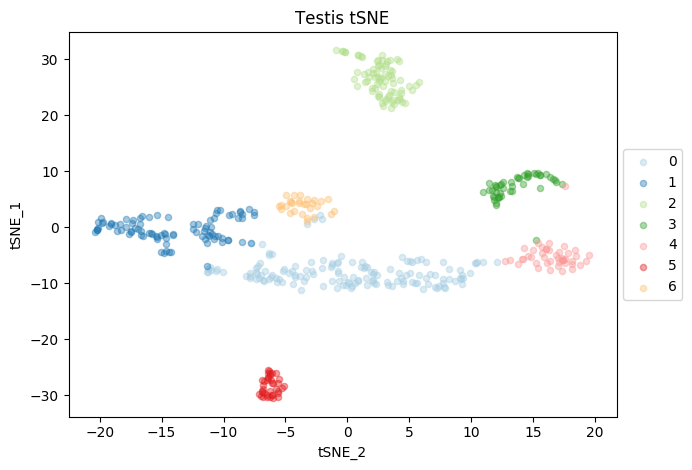

In [182]:
@make_figs(nbconfig.fig_name('tSNE'), nbconfig.styles, nbconfig.formats)
def plot_tSNE():
    _df = tsne.join(ident)
    TSNEPlot('tSNE_2', 'tSNE_1', data=_df, hue='ident', 
                 palette=nbconfig.colors, alpha=.4, title='Testis tSNE')
plot_tSNE()

In [185]:
def plot_gene(symbol=None, fbgn=None, **kwargs):
    if symbol is None:
        symbol = fbgn2symbol[fbgn]

    if fbgn is None:
        fbgn = symbol2fbgn[symbol]

    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1.2, 1]})
    _df = tsne.join(norm.T.copy()[fbgn])
    TSNEPlot('tSNE_2', 'tSNE_1', data=_df, hue=fbgn, s=10, 
             ax=ax1, title='Normalized Expression\n(Continuous)', **kwargs)

    TSNEPlot('tSNE_2', 'tSNE_1', data=_df, hue=_df[fbgn] > 0, 
             cmap={
                 '0': 'w',
                 '1': 'k',
             }, s=10, ax=ax2, alpha=.6, edgecolor='k', title='Normalized Expression\n(Binary)', **kwargs)

    fig.suptitle(f'{symbol} ({fbgn})');

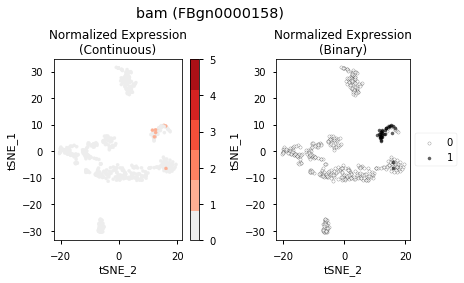

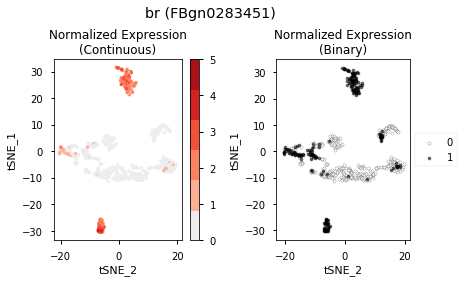

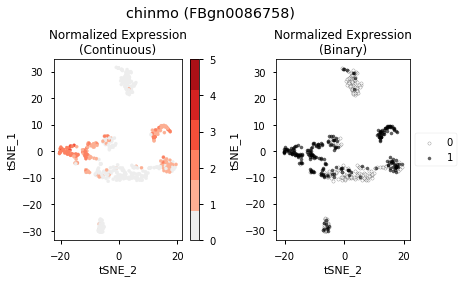

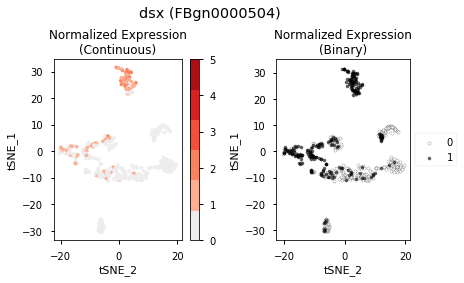

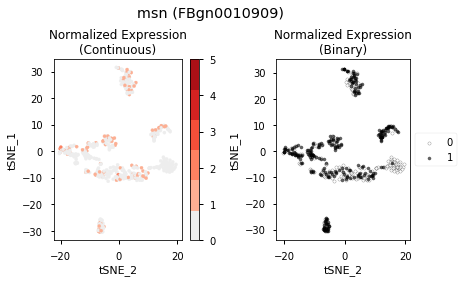

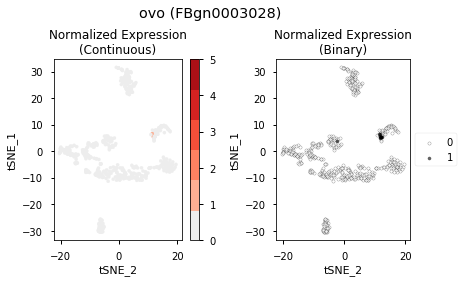

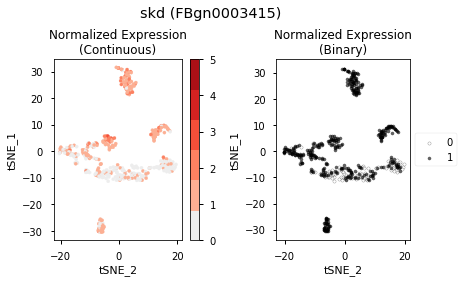

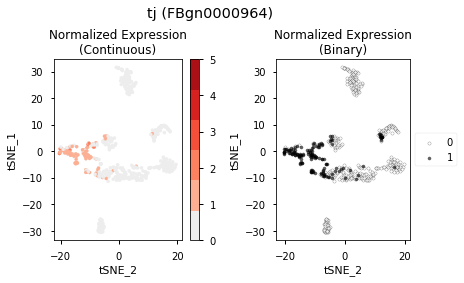

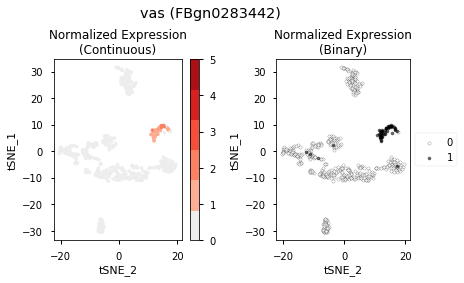

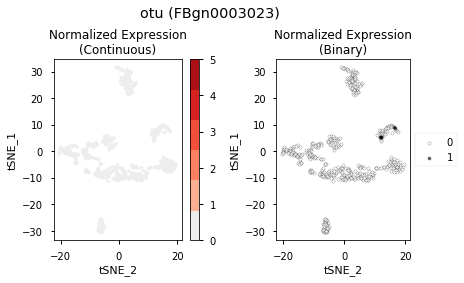

In [197]:
def _plot_gene(*args, **kwargs):
        plot_gene(*args, **kwargs)
        plt.tight_layout(rect=[0, 0, 1, .95])
    
colors = sns.color_palette('Reds')
color2 = sns.color_palette('Greys')
colors[0] = color2[0]

genes = ["bam", "br", "chinmo", "dsx", "msn", "ovo", "skd", "tj", "vas", "otu"]
for g in genes:
    _plot_gene(symbol=g, palette=colors)

# Differential Expression (find biomarkers)

Finally we use Seurat to find differentially expressed genes, which can be used a biomarkers. I require that a gene be present in at least 25% of cells of either cluster (or remaining cells).

**TODO: I am only outputting the positive biomarkers (from seurat webpage), I need to decide if this is what I really want to do.**

In [198]:
%%R -o testis_markers
### Finding differentially expressed genes (cluster biomarkers)
# find markers for every cluster compared to all remaining cells, report only the positive ones
testis_markers = FindAllMarkers(object=testis, only.pos=TRUE, min.pct=0.25, thresh.use=0.25, print.bar=FALSE)

rownames(testis_markers) = NULL

testis_markers %>% group_by(cluster) %>% top_n(2, avg_logFC)

write.table(testis_markers, 
           file=file.path(OUTPUT, 'biomarkers.tsv'),
           quote=FALSE, sep='\t', row.names=FALSE, col.names=TRUE)

In [203]:
testis_markers.index = testis_markers.gene.apply(lambda x: fbgn2symbol[x])

In [207]:
testis_markers.set_index('gene', append=True).groupby('cluster').head()

,,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster
gene,gene,,,,,,
COX7C,FBgn0040773,9.917185e-127,1.020011,1.000,0.915,1.144046e-122,0
Neb-cGP,FBgn0083167,4.053280e-108,0.885442,1.000,0.973,4.675864e-104,0
cype,FBgn0015031,1.251062e-104,0.776660,1.000,1.000,1.443226e-100,0
GstS1,FBgn0010226,8.724888e-101,1.499899,1.000,0.958,1.006503e-96,0
COX8,FBgn0263911,6.724285e-96,0.791223,1.000,0.973,7.757135e-92,0
CG31676,FBgn0051676,1.003078e-83,2.260139,1.000,0.418,1.157150e-79,1
CG43886,FBgn0264478,2.630164e-67,1.913201,0.978,0.281,3.034157e-63,1
SpdS,FBgn0037723,9.341319e-66,1.460045,1.000,0.481,1.077615e-61,1
CG7194,FBgn0035868,1.638334e-64,1.519177,0.989,0.397,1.889982e-60,1


<!--NAVIGATION-->
| [Contents](Index.ipynb) | [Combined Pilot scRNA-Seq](03.00-combined_ovary_and_testis_pilot_scRNAseq_analysis.ipynb) >